In [ ]:
# At a specific time interval (say, every hour) of a single day, 
    # => get an optimal angle (the angle that maximises the radiance)
    # => get the solar-oriented angle
    # => compare the values 
    
# There are potentially two things that went wrong:
#     -> It is worrisome that the optimal angle turns out to be 147 for all hours. I checked a million times why it 
#         is the case, but I can't find the bug. Please, let me know if you find it.  
#     -> I was not sure whether such (the one I used) conversion of solar-oriented angles makes sense. 

In [1]:
import bifacialvf    
import os
# change directory to \bifacialvf\ root
os.chdir(os.path.dirname(bifacialvf.__file__))
%pwd

/Users/eleonorakiziv/Desktop/bifacialvf-master/bifacialvf


u'/Users/eleonorakiziv/Desktop/bifacialvf-master/bifacialvf'

In [2]:
# we are going to do one day first - 1987 year,1 month, 1 day, 8 hour,0 minute => 1st of January 1987 starting at 8:00 

from loadVFresults import loadVFresults
import pandas as pd
from datetime import date, datetime, timedelta

new_dict = {}
value = ()

hour = {8: '08',
        9: '09', 
        10: '10',
        11: '11',
        12: '12',
        13: '13',
        14: '14',
        15: '15',
        16: '16',
        17: '17'}
    
for beta in xrange (1, 148):
    (data, metadata) = loadVFresults("data/Output/Angles/" + str(beta)+'.csv')
    data['measdatetime'] = pd.to_datetime(data[['Year', 'Month', 'Day','Hour', 'Minute']])
    
    # for all hours 
    for integer, string in sorted(hour.items()):
        singlehour = (data['measdatetime'] =='1987-01-01 ' + str (string) + ':00:00')
        data['GTIFrontavg'] = data[['No_1_RowFrontGTI', 'No_2_RowFrontGTI','No_3_RowFrontGTI','No_4_RowFrontGTI','No_5_RowFrontGTI','No_6_RowFrontGTI']].mean(axis=1)
        data['GTIBackavg'] = data[['No_1_RowBackGTI', 'No_2_RowBackGTI','No_3_RowBackGTI','No_4_RowBackGTI','No_5_RowBackGTI','No_6_RowBackGTI']].mean(axis=1)
        front_single_day_sum = data['GTIFrontavg'][singlehour].sum()
        back_single_day_sum = data['GTIBackavg'][singlehour].sum()
        bifacial_ratio = back_single_day_sum/front_single_day_sum*100
        value = (beta, integer)
        new_dict[value] = bifacial_ratio

In [3]:
# I am trying to identify the angles at each hour that maximise radiance. 
max_hour=0
max_rad =0
max_beta=0

# this dictionary is going to hold the optimal angle beta at each hour
hour_beta = {}
# this dictionary is going to hold the radiation, associated with the optimal beta
hour_rad = {}

for integer, string in hour.items(): 
    for beta in xrange(1, 148):
        if new_dict[(beta,  integer)] > max_rad:
            max_rad = new_dict[(beta, integer)]
            max_beta = beta
            hour_beta[integer] = max_beta
            hour_rad[integer] = max_rad
    max_hour=0
    max_rad =0
    max_beta=0
    
       
print hour_beta


{8: 147, 9: 147, 10: 147, 11: 147, 12: 147, 13: 147, 14: 147, 15: 147, 16: 147, 17: 147}


In [4]:
# Since solarpy requires python3, I am just going to upload the resulting dictionary, which specifies the solar-oriented 
# angles at each of the hours we are looking at. 
solar_data = {}
with open('solar_oriented_angles.txt') as raw_data:
    for item in raw_data:
        item.strip('\n')
        if ':' in item:
            key,value = item.split(':')
            value = float(value.strip('\n'))
            key = int(key)
            solar_data[key]=value
print solar_data


{8: -51.453736850512584, 9: -39.61071355874524, 10: -27.763895051784502, 11: -16.17548745869162, 12: -5.081377285035915, 13: 5.38958002762569, 14: 14.461625487511313, 15: 21.937504178096262, 16: 27.135093369096065, 17: 29.436087684239066}


In [5]:
import math 
# radiation received by the optimal angle 
# the radiation received by the sun centered angle on the same axes

# As you can see, the values produced by pysolar range from (-90, 90). However, the model only accepted values 
# from 0 to 147. Having sketched the tilt produced, I was thinking maybe if the value is negative, we just 
# need to add 90 to the abs value of the angle and use the obtained angle. 

# This is a step that should possibly be reconsidered! 

for hour, beta in solar_data.items():
    solar_data[hour] = int(solar_data[hour])
    if solar_data[hour] < 0: 
        beta = 180-math.fabs(solar_data[hour])
        if beta > 147:
            beta = 147
        if beta < 0:
            beta = 0 
        solar_data[hour] = beta
        

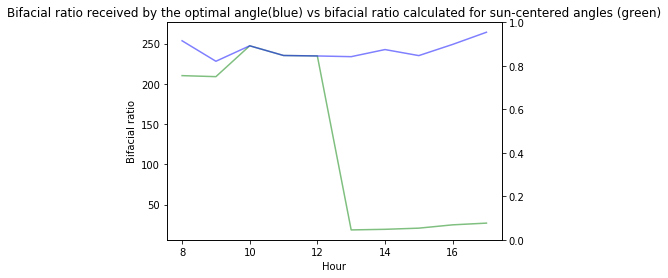

In [6]:
# 'Bifacial ratio received by the optimal angle(blue) vs bifacial ratio calculated for 
# sun-centered angles (green)'

import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.set_title('Bifacial ratio received by the optimal angle(blue) vs bifacial ratio calculated for sun-centered angles (green)')
ax.set_xlabel("Hour")
ax.set_ylabel("Bifacial ratio")

new_list = []

for hour, beta in sorted(solar_data.items()):
    to_add = new_dict[(beta, hour)]
    new_list.append(to_add)
    

ax.plot(sorted(solar_data.keys()), new_list, 'g', alpha = 0.5)
ax.plot(sorted(hour_rad.keys()), hour_rad.values(), 'b', alpha = 0.5)




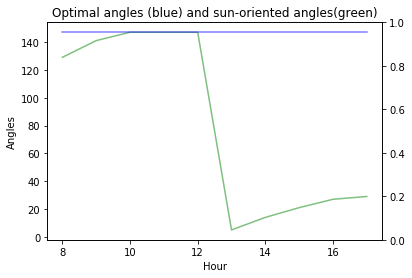

In [7]:
# This graph is going to demonstrate how different the sun-centered and the optimal angles: 
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.set_title('Optimal angles (blue) and sun-oriented angles(green)')
ax.set_xlabel("Hour")
ax.set_ylabel("Angles")

new_list = []

for hour, beta in sorted(solar_data.items()):
    to_add = new_dict[(beta, hour)]
    new_list.append(to_add)
    

ax.plot(sorted(solar_data.keys()), solar_data.values(), 'g', alpha = 0.5)
ax.plot(sorted(hour_beta.keys()), hour_beta.values(), 'b', alpha = 0.5)